# First exploration of Kaggle big five personality data

Ideas:

* Fill in the responses myself and compare my answers to the general
* Do summarize percentage values, accumulating the data together

In [72]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [138]:
rdf = pd.read_csv("../raw/data_final_rekeyed.tsv.gz", delimiter="\t", nrows=1000)
rdf.head()

,Unnamed: 0,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,...,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err
0,0,4.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,4.0,...,2016-03-03 02:01:01,768.0,1024.0,9.0,234.0,6,1,GB,51.5448,0.1991
1,1,3.0,1.0,3.0,2.0,3.0,3.0,2.0,1.0,1.0,...,2016-03-03 02:01:20,1360.0,768.0,12.0,179.0,11,1,MY,3.1698,101.706
2,2,2.0,3.0,4.0,2.0,3.0,4.0,1.0,3.0,2.0,...,2016-03-03 02:01:56,1366.0,768.0,3.0,186.0,7,1,GB,54.9119,-1.3833
3,3,2.0,4.0,2.0,3.0,4.0,4.0,2.0,2.0,1.0,...,2016-03-03 02:02:02,1920.0,1200.0,186.0,219.0,7,1,GB,51.75,-1.25
4,4,3.0,3.0,3.0,3.0,5.0,3.0,3.0,1.0,3.0,...,2016-03-03 02:02:57,1366.0,768.0,8.0,315.0,17,2,KE,1.0,38.0


In [85]:
indices = list()

personality_cats = ["extraversion", "neuroticism", "agreeableness", "conscientiousness", "openness"]

category = list()
for i in range(0,50): 
    gothrough = i % 10
    set_of_questions = i // 10
    question_index = 1 + gothrough * 5 + set_of_questions
    indices.append(question_index)
    category.append(personality_cats[set_of_questions])
    # print(f"index {question_index} got {gothrough} set {set_of_questions}")
print(category)

['extraversion', 'extraversion', 'extraversion', 'extraversion', 'extraversion', 'extraversion', 'extraversion', 'extraversion', 'extraversion', 'extraversion', 'neuroticism', 'neuroticism', 'neuroticism', 'neuroticism', 'neuroticism', 'neuroticism', 'neuroticism', 'neuroticism', 'neuroticism', 'neuroticism', 'agreeableness', 'agreeableness', 'agreeableness', 'agreeableness', 'agreeableness', 'agreeableness', 'agreeableness', 'agreeableness', 'agreeableness', 'agreeableness', 'conscientiousness', 'conscientiousness', 'conscientiousness', 'conscientiousness', 'conscientiousness', 'conscientiousness', 'conscientiousness', 'conscientiousness', 'conscientiousness', 'conscientiousness', 'openness', 'openness', 'openness', 'openness', 'openness', 'openness', 'openness', 'openness', 'openness', 'openness']


In [86]:
question_names = list(df.columns)[1:51]
question_times = list(df.columns)[51:101]

design = pd.DataFrame({
    "question_name":question_names, 
    "question_time":question_times, 
    "category":category,
    "order":indices})
design

design.to_csv("../raw/design.tsv", sep="\t")

# Initial visuals

In [139]:
aggr_data = rdf[design.question_name].agg(['sum', 'count', 'mean', 'median']).T
aggr_data.reset_index(inplace=True)
aggr_data['category'] = design.category
aggr_data.head()

,index,sum,count,mean,median,category
0,EXT1,2642.0,1000.0,2.642,3.0,extraversion
1,EXT2,3308.0,1000.0,3.308,3.0,extraversion
2,EXT3,3408.0,1000.0,3.408,4.0,extraversion
3,EXT4,2875.0,1000.0,2.875,3.0,extraversion
4,EXT5,3389.0,1000.0,3.389,4.0,extraversion


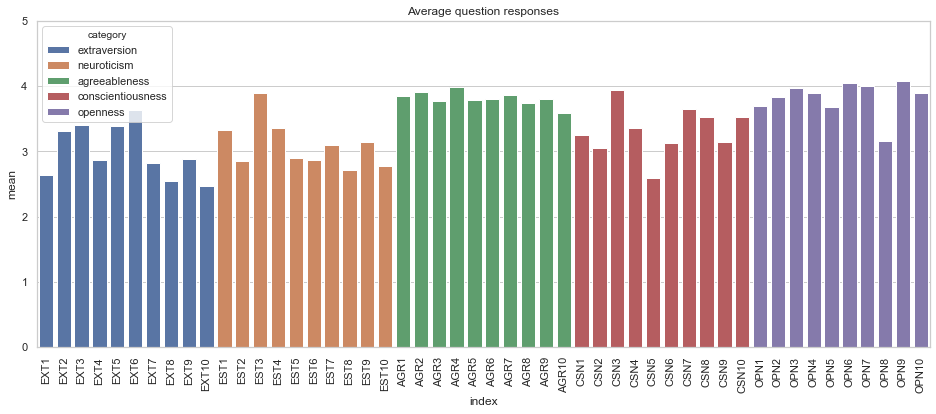

In [126]:
sns.set(style="whitegrid")

plt.figure(figsize=(16,6))
chart = sns.barplot(x="index", y="mean", hue="category", data=aggr_data, dodge=False)
_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
#chart = chart
_ = chart.set_title("Average question responses")
_ = chart.axes.set_ylim(0, 5)


# Aggregating the data

Ideal outputs:

* Output mean score per category
* Also, output ranking for each category, and quartile of scoring

In [329]:
agg_answers = pd.DataFrame()
for category in design.category.unique():
    target_questions = design[design.category == category].question_name
    df = rdf[target_questions]
    means = df.agg(['mean'], axis=1)
    agg_answers[category] = means['mean'].to_list()

agg_answers.columns = [f'{col}_mean' for col in agg_answers.columns]
    
summarized_data = agg_answers
# df[design.question_name].agg(['sum', 'count', 'mean', 'median']).T

In [301]:
def calc_index(values):
    val_position = np.argsort(values.to_list()) + 1
    return val_position

def calc_percentiles(values):
    val_position = np.argsort(values.to_list())
    perc = val_position / max(val_position) * 100
    return perc

In [320]:
agg_ind_colnames

['extraversion_rank',
 'neuroticism_rank',
 'agreeableness_rank',
 'conscientiousness_rank',
 'openness_rank']

In [330]:
agg_indices = agg_answers[1:10].apply(calc_index, axis=0)
agg_percentiles = agg_answers[1:10].apply(calc_percentiles, axis=0)

agg_indices.columns = [f'{col}_rank' for col in agg_indices.columns]
agg_percentiles.columns = [f'{col}_perc' for col in agg_percentiles.columns]

pd.concat([agg_answers[1:10], agg_indices, agg_percentiles], axis=1)

,extraversion_mean,neuroticism_mean,agreeableness_mean,conscientiousness_mean,openness_mean,extraversion_mean_rank,neuroticism_mean_rank,agreeableness_mean_rank,conscientiousness_mean_rank,openness_mean_rank,extraversion_mean_perc,neuroticism_mean_perc,agreeableness_mean_perc,conscientiousness_mean_perc,openness_mean_perc
1,2.0,2.5,4.4,3.7,3.5,1,7,9,9,1,0.0,75.0,100.0,100.0,0.0
2,2.5,2.6,4.2,3.4,4.1,9,4,3,3,9,100.0,37.5,25.0,25.0,100.0
3,2.6,2.9,3.8,2.5,3.9,2,5,5,8,3,12.5,50.0,50.0,87.5,25.0
4,2.9,1.9,4.6,4.8,4.8,3,1,7,6,2,25.0,0.0,75.0,62.5,12.5
5,3.2,2.2,3.8,3.7,4.4,4,2,6,2,6,37.5,12.5,62.5,12.5,62.5
6,3.5,3.0,4.1,3.3,4.3,5,3,2,1,7,50.0,25.0,12.5,0.0,75.0
7,4.2,1.6,3.8,4.5,4.3,8,6,1,5,5,87.5,62.5,0.0,50.0,50.0
8,3.2,3.0,4.5,3.1,4.5,6,8,8,7,8,62.5,87.5,87.5,75.0,87.5
9,2.2,3.1,1.9,1.7,3.5,7,9,4,4,4,75.0,100.0,37.5,37.5,37.5


In [168]:
agg_answers

,extraversion,neuroticism,agreeableness,conscientiousness,openness


In [157]:
pd.DataFrame.from_dict(agg_answers)

ValueError: If using all scalar values, you must pass an index

In [151]:
keys(agg_answers)

NameError: name 'keys' is not defined